In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from functools import partial

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
FashionMNIST = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Image shape: torch.Size([1, 28, 28])
Image min and max: tensor(0.) tensor(1.)
label: 9


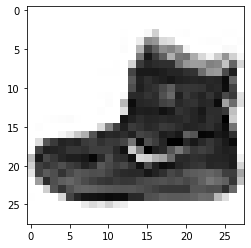

In [4]:
im, label = FashionMNIST[0]
print('Image shape:', im.shape)
print('Image min and max:', im.min(), im.max())
print('label:', label)
plt.imshow(im[0], cmap='Greys');

In [5]:
#see how we can make a dataloader to serve the data in batches for training
train_dataloader = DataLoader(FashionMNIST, batch_size=8, shuffle = True)
x, y = next(iter(train_dataloader))
x.shape, y

(torch.Size([8, 1, 28, 28]), tensor([4, 4, 7, 6, 9, 8, 1, 0]))

In [6]:
def corrupt(x, amount):
  #Corrupt input 'x' by mixing it with noise according to specified amount
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) #sort shape so broadcasting works
  return x*(1-amount) + noise*amount

In [7]:
class BasicUNet(nn.Module):
  #Minimal UNet implementation
  def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([ 
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2), 
        ])
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

  def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            h.append(x)
            if i < 2: x = self.downscale(x)
        for i, l in enumerate(self.up_layers):
            if i > 0: x = self.upscale(x)
            x += h.pop()
            x = self.act(l(x))
        return x

In [8]:
unet = BasicUNet(1, 2)
unet(torch.rand(8, 1, 28, 28)).shape

torch.Size([8, 2, 28, 28])

In [9]:
sum([p.numel() for p in unet.parameters()]) 

309858

In [10]:
#create the network for single channel input and output images
net = BasicUNet(1, 1)

#feed some data through:
x.shape, net(x).shape

(torch.Size([8, 1, 28, 28]), torch.Size([8, 1, 28, 28]))

Finished epoch 0. Average of the last 100 loss values: 0.025527
Finished epoch 1. Average of the last 100 loss values: 0.022951
Finished epoch 2. Average of the last 100 loss values: 0.020640
Finished epoch 3. Average of the last 100 loss values: 0.020391
Finished epoch 4. Average of the last 100 loss values: 0.019707
Finished epoch 5. Average of the last 100 loss values: 0.019043
Finished epoch 6. Average of the last 100 loss values: 0.018692
Finished epoch 7. Average of the last 100 loss values: 0.018481
Finished epoch 8. Average of the last 100 loss values: 0.018219
Finished epoch 9. Average of the last 100 loss values: 0.017823


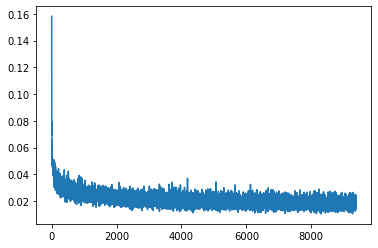

In [11]:
#Dataloader
train_dataloader = DataLoader(FashionMNIST, batch_size=64, shuffle=True)

n_epochs= 10

#Create the network
net=BasicUNet(1, 1)
net.to(device)

#loss function
loss_fn= nn.MSELoss()

#optimizer
opt = torch.optim.Adam(net.parameters(), lr=3e-4)

#keeping record of losses
losses = []

#record of smoothed loss values after each epoch
smoothed_losses_basic = []

#training loop
for epoch in range(n_epochs):
  for x, y in train_dataloader:

    #get data then prepare corruption
    x = x.to(device) #data on the GPU
    noise_amount = torch.rand(x.shape[0]).to(device) #pick random noise amounts
    noisy_x = corrupt(x, noise_amount) #create noisy x

    #get model prediction
    pred = net(noisy_x)

    #calculate loss
    loss = loss_fn(pred, x) #how close is the output to the true 'clean' x?

    #backprop and update the params
    opt.zero_grad()
    loss.backward()
    opt.step()

    #store the loss for later
    losses.append(loss.item())

  #print avf of the lass 100 loss values to get an idea of progress:
  avg_loss = sum(losses[-100:])/100
  smoothed_losses_basic.append(avg_loss)
  print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)

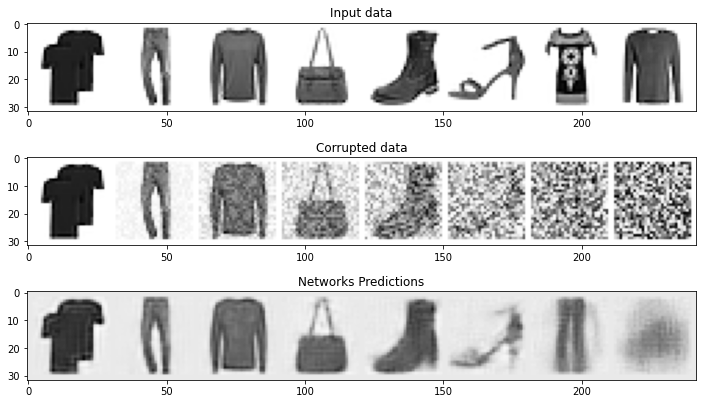

In [12]:
#viewing model predictions
#fetch data
x, y = next(iter(train_dataloader))
x = x[:8] #use first 8 for ease

#corrupt with a range
amount = torch.linspace(0, 1, x.shape[0]) #left to right -> more corruption
noised_x = corrupt(x, amount)

#Get model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

#plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap='Greys')
axs[2].set_title('Networks Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0], cmap='Greys')

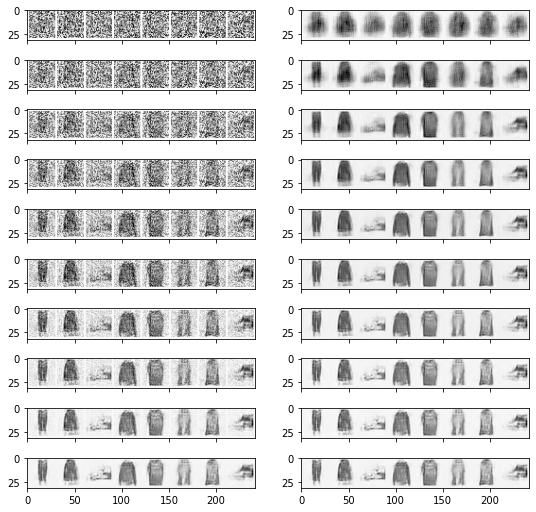

In [13]:
#Sampling
#breaking process into 10 steps and moving 1/10th of the way
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) #start from random
step_history = []
pred_output_history = []

for i in range(n_steps):
  with torch.no_grad(): #unnecessary to track gradients during inference
    pred = net(x) #predict the denoised x0
  pred_output_history.append(pred.detach().cpu()) #store model output for plotting
  mix_factor = 1/(n_steps - i) #how much we move towards the prediction
  x = x*(1-mix_factor) + pred*mix_factor #move part of the way there
  step_history.append(x.detach().cpu()) #store steps for plottings

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
for i in range(n_steps):
  axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys'),
  axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0], cmap = 'Greys')

In [14]:
class NoiseConditionedUNet(nn.Module):
    """Wraps a BasicUNet but adds an extra input channel for the conditioning."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.net = BasicUNet(in_channels+1, out_channels)

    def forward(self, x, noise_amount):
        # Shape of x
        bs, ch, w, h = x.shape
        
        # Get noise_amount as a single channel 'image' the same shape as x
        if not torch.is_tensor(noise_amount):
            noise_amount = x.new_full((x.size(0),), noise_amount)
        noise_amount = noise_amount.view(-1, 1, 1, 1).expand(bs, 1, w, h) # If x.shape is [8,3,28,28] noise_amount is [8,1,28, 28]
        
        # Concatenate this onto x to get the final net input:
        net_input = torch.cat((x, noise_amount), 1)
        
        # Now pass through the net to get the prediction as before
        return self.net(net_input)

In [15]:
#Noise conditioning
net = NoiseConditionedUNet(1, 1)

# Now we need both x and noise_amount to make predictions:
x, y = next(iter(train_dataloader))
bs = x.shape[0]
noise_amount = torch.rand([bs])
x.shape, net(x, noise_amount).shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

Finished epoch 0. Average of the last 100 loss values: 0.025428
Finished epoch 1. Average of the last 100 loss values: 0.022233
Finished epoch 2. Average of the last 100 loss values: 0.020742
Finished epoch 3. Average of the last 100 loss values: 0.019746
Finished epoch 4. Average of the last 100 loss values: 0.018479
Finished epoch 5. Average of the last 100 loss values: 0.018256
Finished epoch 6. Average of the last 100 loss values: 0.018560
Finished epoch 7. Average of the last 100 loss values: 0.017997
Finished epoch 8. Average of the last 100 loss values: 0.017450
Finished epoch 9. Average of the last 100 loss values: 0.017499


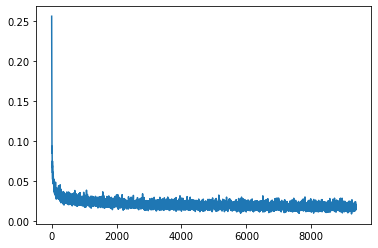

In [16]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(FashionMNIST, batch_size=64, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our new network type: 
net = NoiseConditionedUNet(1, 1) # <<< Using our new noise conditioned net
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=3e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_noise_cond = []

# The training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, noise_amount) # <<<<<<

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_noise_cond.append(avg_loss)
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

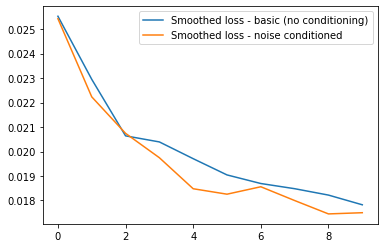

In [17]:
# Comparing the training curves of the two vairants
plt.plot(smoothed_losses_basic, label='Smoothed loss - basic (no conditioning)')
plt.plot(smoothed_losses_noise_cond, label='Smoothed loss - noise conditioned')
plt.legend();

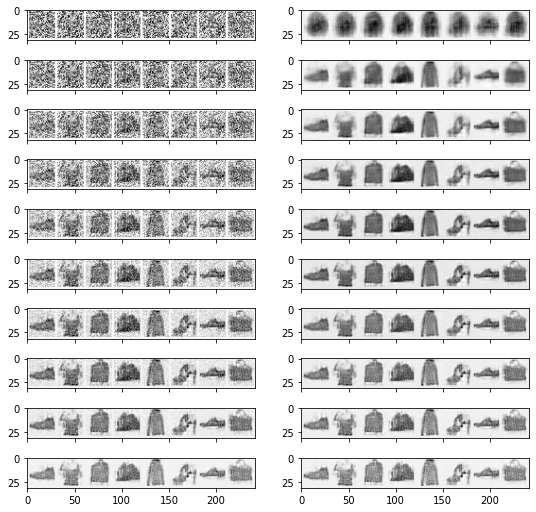

In [18]:
# Sampling as before, but conditioning on an estimated noise amount:
n_steps = 10
x = torch.rand(8, 1, 28, 28).to(device) # Start from random
step_history = []
pred_output_history = []

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x, noise_amount) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there # Should it be (pred-x) instead of pred?
    step_history.append(x.detach().cpu()) # Store for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 9), sharex=True)
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0], cmap='Greys'),
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0], cmap='Greys')

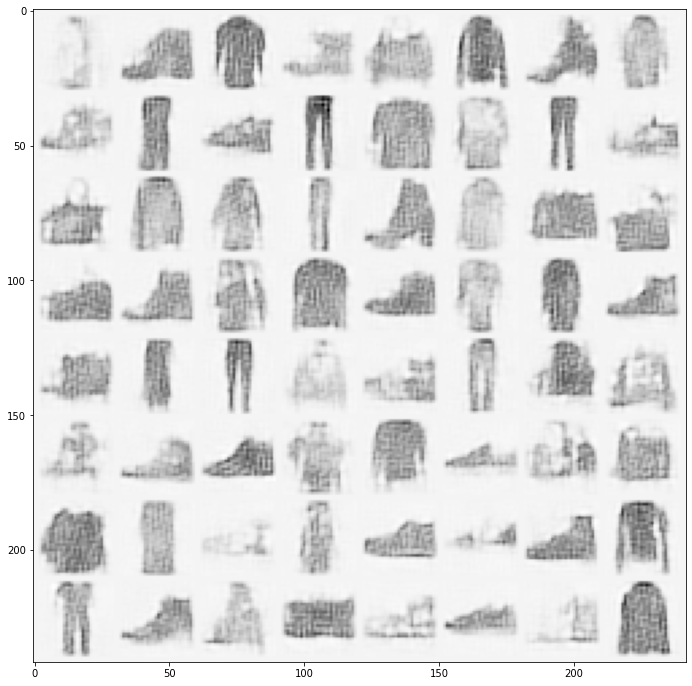

In [19]:
# Try some at higher steps
n_steps = 20 # Try 2, 5, 10, 50 - how does it affact things?
x = torch.rand(64, 1, 28, 28).to(device)
history = [x.detach().cpu()]

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
    with torch.no_grad():
        pred = net(x, noise_amount)
    mix_factor = 1/(n_steps - i) # Explain how we're moving linearly towards the solution
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0], cmap='Greys')

In [20]:
class NoiseAndClassConditionedUNet(nn.Module):
    """Wraps a BasicUNet but adds an extra input channel for the conditioning and several input 
    channels for class conditioning. An nn.Embedding layer maps num_classes to class_emb_channels."""
    def __init__(self, in_channels, out_channels, num_classes=10, class_emb_channels=4):
        super().__init__()
        self.class_emb = nn.Embedding(num_classes, class_emb_channels) # Map num_classes discrete classes to class_emb_channels numbers
        self.net = BasicUNet(in_channels+1+class_emb_channels, out_channels) # Note input channels = in_channels+1+class_emb_channels

    def forward(self, x, noise_amount, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape
        
        # Get noise_amount the same shape as x
        if not torch.is_tensor(noise_amount):
            noise_amount = x.new_full((x.size(0),), noise_amount)
        noise_amount = noise_amount.view(-1, 1, 1, 1).expand(bs, 1, w, h)
        
        # And the class cond
        class_cond = self.class_emb(class_labels) # Map to embedding dinemsion
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h) # Reshape
        
        # Net input is now x, noise amound and class cond concatenated together
        net_input = torch.cat((x, noise_amount, class_cond), 1)
        return self.net(net_input)

In [21]:
# Creating a network
net = NoiseAndClassConditionedUNet(1, 1)

# Now we need x, noise_amount AND y to make predictions:
x, y = next(iter(train_dataloader))
bs = x.shape[0]
noise_amount = torch.rand([bs])
x.shape, net(x, noise_amount, y).shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 1, 28, 28]))

Finished epoch 0. Average of the last 100 loss values: 0.023443
Finished epoch 1. Average of the last 100 loss values: 0.019538
Finished epoch 2. Average of the last 100 loss values: 0.018020
Finished epoch 3. Average of the last 100 loss values: 0.017000
Finished epoch 4. Average of the last 100 loss values: 0.016545
Finished epoch 5. Average of the last 100 loss values: 0.015418
Finished epoch 6. Average of the last 100 loss values: 0.015445
Finished epoch 7. Average of the last 100 loss values: 0.015034
Finished epoch 8. Average of the last 100 loss values: 0.014994
Finished epoch 9. Average of the last 100 loss values: 0.014756


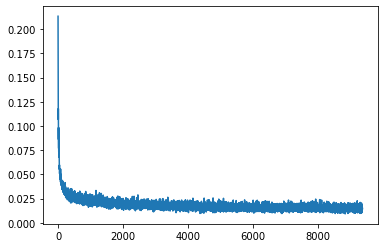

In [23]:
# Dataloader (you can mess with batch size)
train_dataloader = DataLoader(FashionMNIST, batch_size=64, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Our new network type: 
net = NoiseAndClassConditionedUNet(1, 1) # <<< Using our new noise and class conditioned net
net.to(device) # We want to train on the GPU if that is available

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer - explore different learning rates or try
# a different optimizer instead
opt = torch.optim.Adam(net.parameters(), lr=3e-4) 

# Keeping a record of the losses for later viewing
losses = []

# And a record of smoothed loss values after each epoch
smoothed_losses_class_cond = []

# The training loop
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        
        # Get some data and prepare the corrupted version
        x = x.to(device) # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device) # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount) # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, noise_amount, y.to(device)) # <<<<<<

        # Calculate the loss
        loss = loss_fn(pred, x) # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    smoothed_losses_class_cond.append(avg_loss)
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)

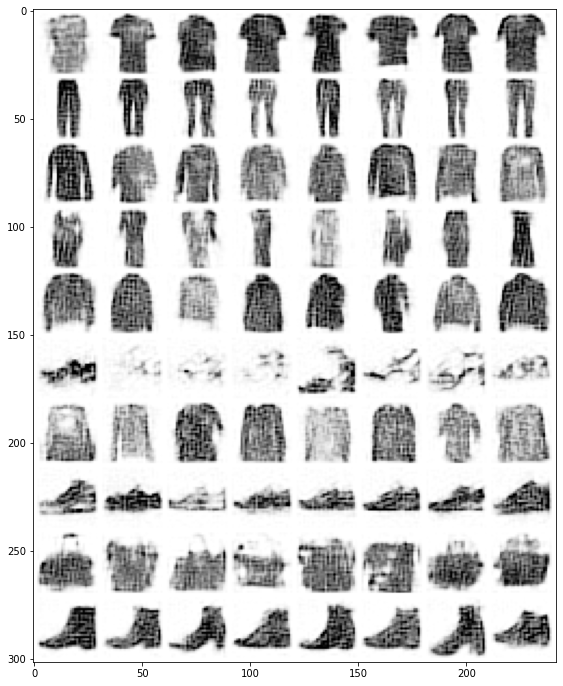

In [24]:
n_steps = 20
x = torch.rand(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)
history = [x.detach().cpu()]

for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps))
    with torch.no_grad():
        pred = net(x, noise_amount, y)
    mix_factor = 1/(n_steps - i)
    x = x*(1-mix_factor) + pred*mix_factor

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(0, 1), nrow=8)[0], cmap='Greys')

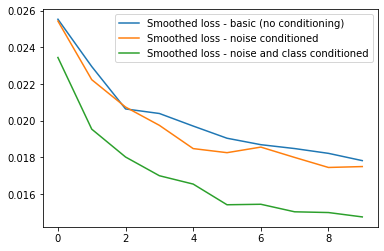

In [25]:
plt.plot(smoothed_losses_basic, label='Smoothed loss - basic (no conditioning)')
plt.plot(smoothed_losses_noise_cond, label='Smoothed loss - noise conditioned')
plt.plot(smoothed_losses_class_cond, label='Smoothed loss - noise and class conditioned')
plt.legend();

In [28]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 212 kB 63.7 MB/s 
     |████████████████████████████████| 182 kB 72.9 MB/s 
     |████████████████████████████████| 132 kB 74.9 MB/s 
     |████████████████████████████████| 127 kB 56.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [29]:
from torchvision import transforms
from datasets import load_dataset
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/huggan___parquet/huggan--smithsonian_butterflies_subset-7665b1021a37404c/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [30]:
dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train") # A smaller dataset featuring butterflies

image_size = 32
batch_size = 32

preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [31]:
!pip install diffusers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 503 kB 5.0 MB/s 


In [32]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

X shape torch.Size([8, 3, 32, 32])
Noisy X shape torch.Size([8, 3, 32, 32])


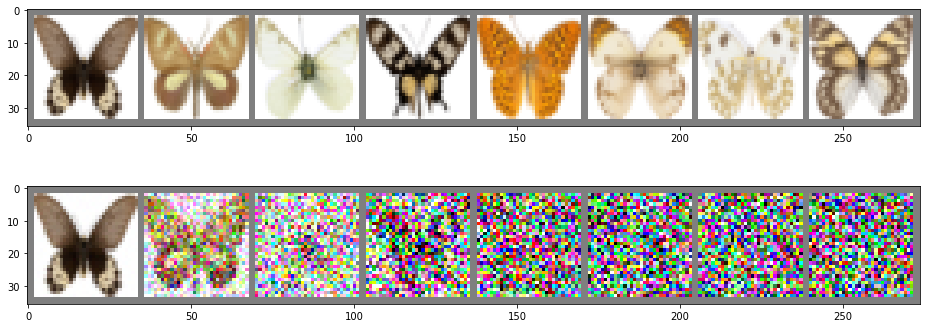

In [33]:
# Noise a batch of images to view the effect
fig, axs = plt.subplots(2, 1, figsize=(16, 6))
xb = next(iter(train_dataloader))['images'].to(device)[:8]
print('X shape', xb.shape)
axs[0].imshow(torchvision.utils.make_grid(xb[:8]).detach().cpu().permute(1, 2, 0)*0.5 + 0.5)

timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print('Noisy X shape', noisy_xb.shape)
axs[1].imshow(torchvision.utils.make_grid(noisy_xb[:8]).clip(-1, 1).detach().cpu().permute(1, 2, 0)*0.5 + 0.5)

In [34]:
from diffusers import UNet2DModel

In [35]:
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 256),  # <<< smaller than their eg
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
)
model.to(device);

In [36]:
# Make sure the shapes work by pushing our noisy batch through
model_output = model(noisy_xb, timestep=timesteps).sample
print('Output shape:', model_output.shape)

Output shape: torch.Size([8, 3, 32, 32])


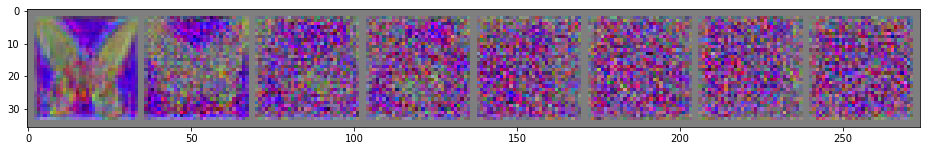

In [37]:
# Plot the outputs as they currently stand:
fig, axs = plt.subplots(1, 1, figsize=(16, 3))
axs.imshow(torchvision.utils.make_grid(model_output[:8]).clip(-1, 1).detach().cpu().permute(1, 2, 0)*0.5 + 0.5);

In [38]:
sum([p.numel() for p in model.parameters()]) # That's a lot of parameters!

16056451

In [39]:
import torch.nn.functional as F

In [40]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

losses = []

for epoch in range(25):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch['images'].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
        
        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
        
        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch+1)%5 == 0: print(epoch, sum(losses[-len(train_dataloader):])/len(train_dataloader))

4 0.08570814516860992
9 0.061552578350529075
14 0.049572148418519646
19 0.05079452256904915
24 0.05310570594156161


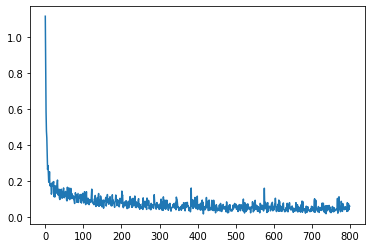

In [41]:
plt.plot(losses)

In [42]:
import PIL.Image
import numpy as np
import tqdm
import pdb

In [43]:
#Sampling
def display_sample(sample, text=None, size=None):
    # NB: clip to avoid overflows changing the display (issue in diffusers docs)
    image_processed = sample.cpu().permute(0, 2, 3, 1).clip(-1,1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)
    image_pil = PIL.Image.fromarray(image_processed[0])
    if size != None:
        image_pil = image_pil.resize(size)
    if text:
        display(text)
    display(image_pil)

In [44]:
from diffusers import DDIMScheduler

'prev_sample and pred_original_sample at step: 9 (timestep 750)'

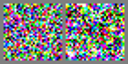

'prev_sample and pred_original_sample at step: 19 (timestep 500)'

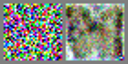

'prev_sample and pred_original_sample at step: 29 (timestep 250)'

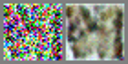

'prev_sample and pred_original_sample at step: 39 (timestep 0)'

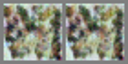

In [45]:
# Doesn't have to be the same as scheduler we trained with
sampling_scheduler = DDIMScheduler(num_train_timesteps=1000)
sampling_scheduler.set_timesteps(40)

# Sample with this new scheduler
sample = torch.randn(1, 3, 32, 32).to(device)
for i, t in enumerate(sampling_scheduler.timesteps):
    
  # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = sampling_scheduler.step(residual, t, sample).prev_sample

    # 3. optionally look at image
    if (i + 1) % 10 == 0:
        # Soon we can do:
        # pred_original_sample = scheduler.step(residual, t, sample).pred_original_sample 
        # But for now we steal code from step:
        # Look at predicted output image if this is the noise (see sampler code for formula)
        alpha_prod_t = sampling_scheduler.alphas_cumprod[t]
        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (sample - beta_prod_t ** (0.5) * residual) / alpha_prod_t ** (0.5)

        preview_im = torchvision.utils.make_grid(torch.cat([sample, pred_original_sample], dim=0)).unsqueeze(0)
        display_sample(preview_im, f'prev_sample and pred_original_sample at step: {i} (timestep {t})', size=(128, 64))

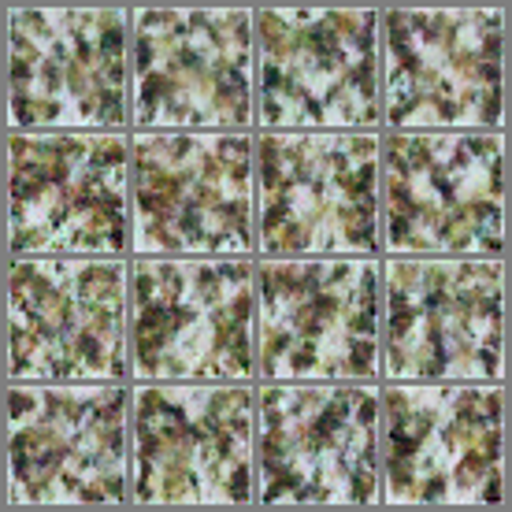

In [46]:
sampling_scheduler = DDIMScheduler(num_train_timesteps=1000)
sampling_scheduler.set_timesteps(50)
sample = torch.randn(16, 3, 32, 32).to(device)
for i, t in enumerate(sampling_scheduler.timesteps):
    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = sampling_scheduler.step(residual, t, sample).prev_sample

preview_im = torchvision.utils.make_grid(sample, nrow=4).unsqueeze(0)
display_sample(preview_im, size=((32*4*4, 32*4*4)))